In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
# Load dataset
df = pd.read_csv(r'data\dataset.csv')

# Display dataset information
print(df.info())
# Print Churn Data
print(df['Churn'].value_counts())

# Convert to int
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- We can see that customers who churn represent roughly 25% of the data. This means we have a class imbalance and we'll have consider that in our model


- Next, we'll transform our categorical columns into dummy variables, so we can see the correlation of the data

In [20]:
df = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)
df_corr = df.corrwith(df['Churn_Yes']).sort_values(ascending=False)

top_20 = pd.concat([df_corr.head(5), df_corr.tail(5)])
plt.figure(figsize=(10,6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Axes: title={'center': 'Top 20 Positive and Negative Correlations with Churn'}, xlabel='None'>

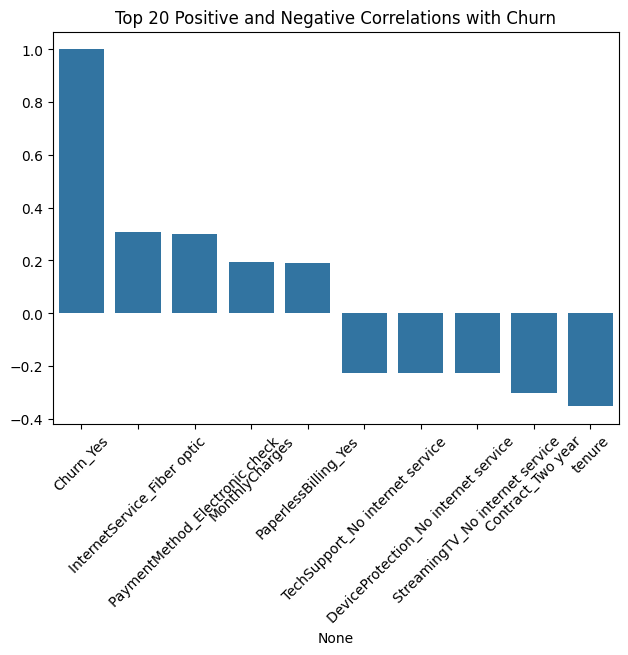

In [21]:
plt.title('Top 20 Positive and Negative Correlations with Churn')
plt.xticks(rotation=45)
plt.tight_layout()
sns.barplot(x=top_20.index, y=top_20.values)


- Here we can see the top 10 features that increase churn and the top 10 features that decrease it
- We'll work with these featureso only from now on, to facilitate our analyisis and to ensure that only relevant features are kept in our model

## Identifying confounding variables

- After we get the correlation between all variables, we see that a lot of them are correlated between each other, which can cause performance and bias issues

We'll remove them as to not influence or model. For the purpose of this model, we'll only remove variables with a 1 to 1 correlation, meaning they're perfectly correlated.
This happens because of "No Internet Service" - which is an entry in multiple features


In [ ]:
correlation_matrix = df.corr()

# Find pairs of features with high correlation
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) == 1:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature1_corr': correlation_matrix.iloc[i, correlation_matrix.columns.get_loc("Churn_Yes")],
                'feature2': correlation_matrix.columns[j],
                'feature2_corr': correlation_matrix.iloc[j, correlation_matrix.columns.get_loc("Churn_Yes")],
                'correlation': correlation_matrix.iloc[i, j]
            })

# Display
high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)

print("Highly correlated feature pairs:")
print(high_corr_df)

# Drop one of each pair of highly correlated features, wich lowest absolute correlation with target
features_to_drop = set()
for index, row in high_corr_df.iterrows():
    if abs(row['feature1_corr']) < abs(row['feature2_corr']):
        features_to_drop.add(row['feature1'])
    else:
        features_to_drop.add(row['feature2'])
    


Highly correlated feature pairs:
                                feature1  feature1_corr  \
1                     InternetService_No      -0.227890   
2                     InternetService_No      -0.227890   
4                     InternetService_No      -0.227890   
3                     InternetService_No      -0.227890   
5                     InternetService_No      -0.227890   
6                     InternetService_No      -0.227890   
14      OnlineBackup_No internet service      -0.227890   
7     OnlineSecurity_No internet service      -0.227890   
8     OnlineSecurity_No internet service      -0.227890   
9     OnlineSecurity_No internet service      -0.227890   
10    OnlineSecurity_No internet service      -0.227890   
11    OnlineSecurity_No internet service      -0.227890   
12      OnlineBackup_No internet service      -0.227890   
13      OnlineBackup_No internet service      -0.227890   
18  DeviceProtection_No internet service      -0.227890   
15      OnlineBackup_No

We'll now analyse our numerical variables distribution vs churn

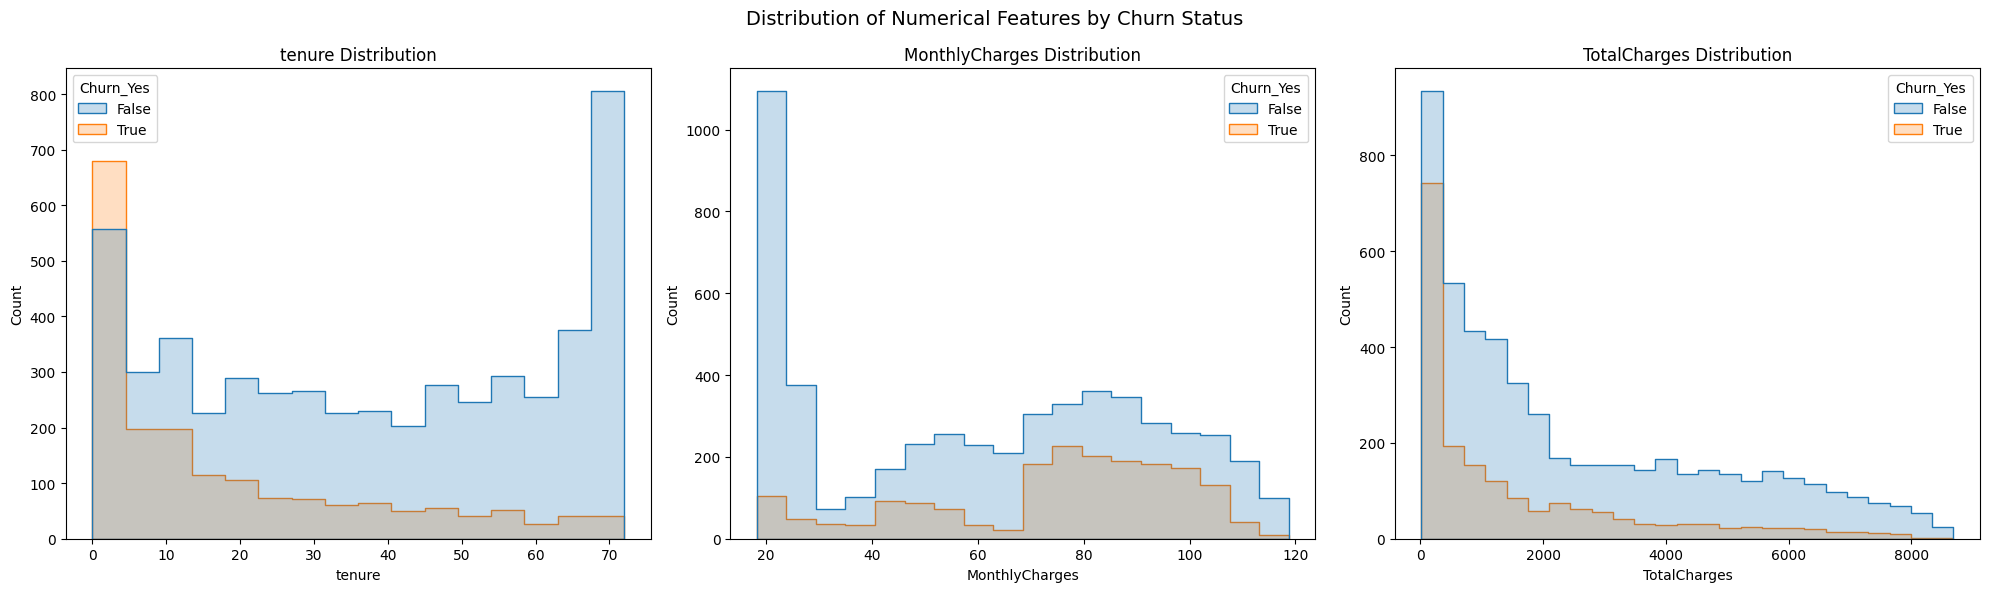

In [23]:
# Analyze numerical variables distribution vs churn
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create subplots in a single figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of Numerical Features by Churn Status', fontsize=14)

# Plot each feature
for idx, feature in enumerate(numerical_features):
    sns.histplot(
        data=df,
        x=feature,
        hue='Churn_Yes',
        element='step',
        ax=axes[idx]
    )
    axes[idx].set_title(f'{feature} Distribution')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

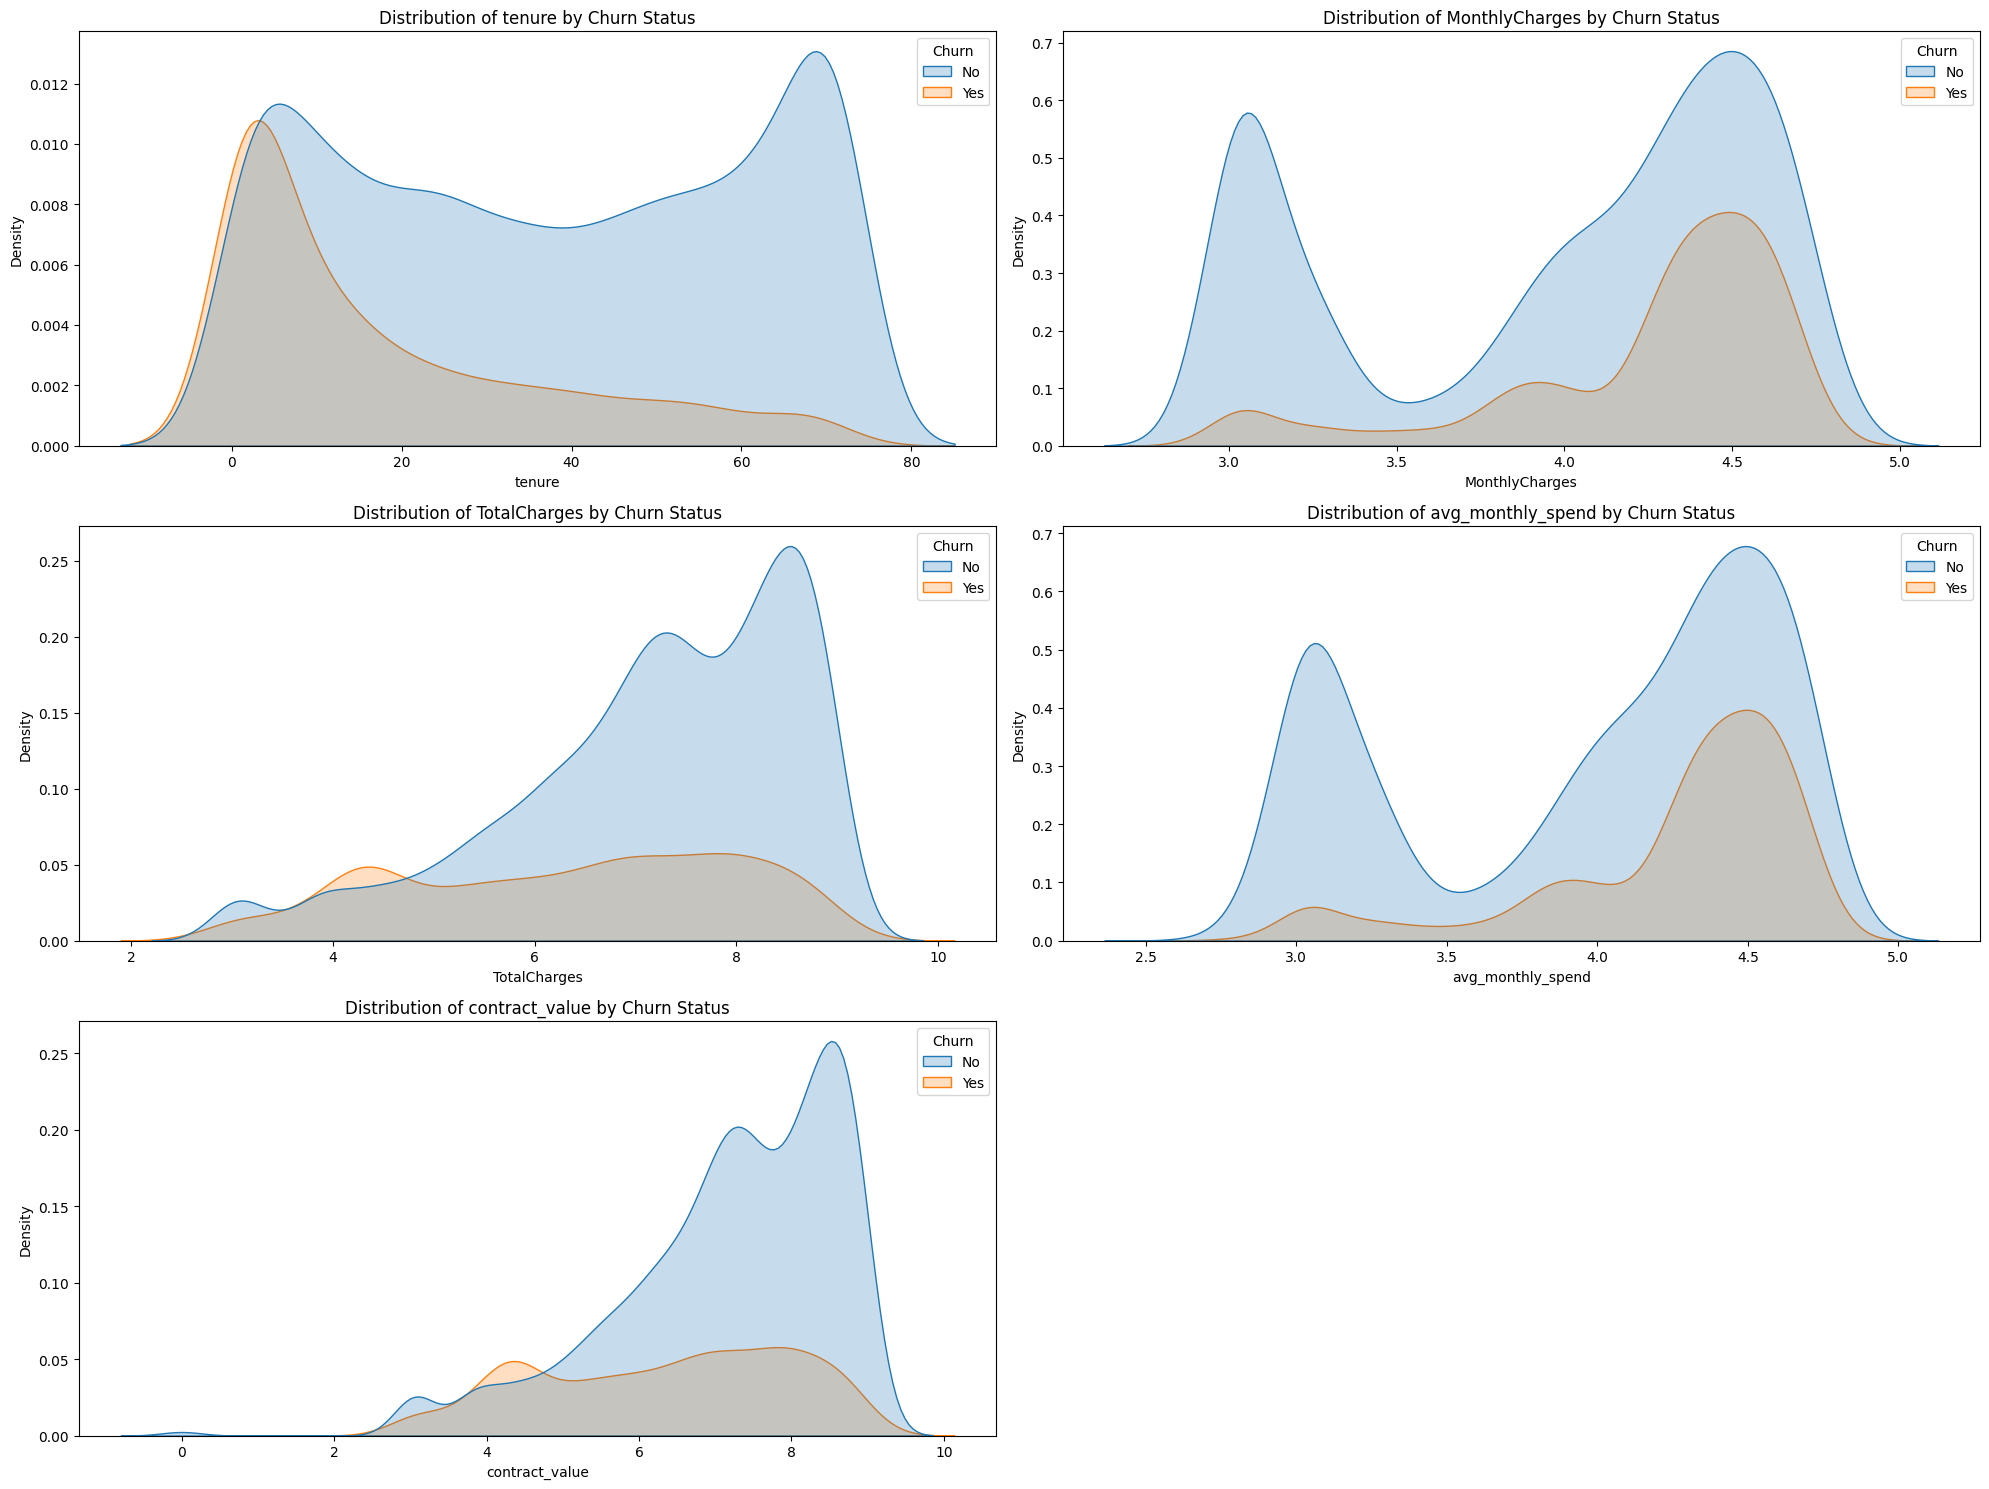

In [24]:
import numpy as np
df = pd.read_csv(r'data\dataset.csv')
# Convert to int
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
# Convert 'tenure' into categorical bins
df['tenure_group'] = pd.cut(df['tenure'], 
                            bins=[0, 6, 12, 24, 48, 72], 
                            labels=['<6m', '6-12m', '12-24m', '24-48m', '48m+'])



# Average Monthly Spend
df['avg_monthly_spend'] = df['TotalCharges'] / df['tenure']
df['contract_value'] = df['MonthlyCharges'] * df['tenure']
df['low_charge'] = df['MonthlyCharges'].apply(lambda x: '1' if x < 30 else '0')

# natural log feature
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: np.log(x + 1))
df['MonthlyCharges'] = df['MonthlyCharges'].apply(lambda x: np.log(x + 1))
df['avg_monthly_spend'] = df['avg_monthly_spend'].apply(lambda x: np.log(x + 1))
df['contract_value'] = df['contract_value'].apply(lambda x: np.log(x + 1))


#KDE plots for numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_spend', 'contract_value']
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=feature, hue='Churn', fill=True)
    plt.title(f'Distribution of {feature} by Churn Status')
plt.tight_layout()
plt.show()


We are now ready to start processing our data for modeling

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import skops.io as skio
import lightgbm as lgb

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Define features
numerical_features = ['MonthlyCharges', 'tenure', 'TotalCharges', 'avg_monthly_spend', 'contract_value']
categorical_features = [col for col in df.columns if col not in numerical_features + ['Churn']]

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")


# Separate features and target FIRST
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

print(f"\nDataset shape: {X.shape}")


# Split data BEFORE preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='mean')), 
            ('scale', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('impute', SimpleImputer(strategy='constant', fill_value='missing')), 
            ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), categorical_features)
    ],
    remainder='drop'
)

# Define cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# lightGBM Pipeline
lgbm_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

# XGBoost Pipeline
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=RANDOM_STATE, 
        objective='binary:logistic'
    ))
])

# Decision Tree Pipeline  
dt_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Parameter grids
lightgbm_param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0],
    'classifier__reg_alpha': [0.1, 0.5],
    'classifier__reg_lambda': [1, 1.5, 2],
    'classifier__scale_pos_weight': [1, 4]
}
xgb_param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [3],
    'classifier__learning_rate': [0.05],
    'classifier__subsample': [0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.9, 1.0],
    'classifier__gamma': [0.1],
    'classifier__reg_alpha': [0.1],
    'classifier__reg_lambda': [1, 1.5, 2],
    'classifier__scale_pos_weight': [1, 2, 4]
}

dt_param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced', None]
}

# Train XGBoost
print("\n" + "="*60)
print("Training XGBoost...")
print("="*60)

grid_search_xgb = GridSearchCV(
    xgb_pipeline, 
    xgb_param_grid, 
    cv=stratified_cv, 
    scoring=['recall', 'roc_auc', 'f1', 'accuracy', 'precision'], 
    n_jobs=-1, 
    refit='f1', 
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)
best_model_xgb = grid_search_xgb.best_estimator_

# Evaluate XGBoost
y_pred_xgb = best_model_xgb.predict(X_test)

print("\nXGBoost Results:")
print("Best parameters:", grid_search_xgb.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Train Decision Tree
print("\n" + "="*60)
print("Training Decision Tree...")
print("="*60)

grid_search_dt = GridSearchCV(
    dt_pipeline, 
    dt_param_grid, 
    cv=stratified_cv, 
    scoring=['recall', 'roc_auc', 'f1'], 
    n_jobs=-1, 
    refit='f1', 
    verbose=1
)

grid_search_dt.fit(X_train, y_train)
best_model_dt = grid_search_dt.best_estimator_

# Evaluate Decision Tree
y_pred_dt = best_model_dt.predict(X_test)

print("\nDecision Tree Results:")
print("Best parameters:", grid_search_dt.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

grid_search_lgbm = GridSearchCV(
    lgbm_pipeline, 
    lightgbm_param_grid, 
    cv=stratified_cv, 
    scoring=['recall', 'roc_auc', 'f1'], 
    n_jobs=-1, 
    refit='f1', 
    verbose=1
)
grid_search_lgbm.fit(X_train, y_train)
best_model_lgbm = grid_search_lgbm.best_estimator_
# Evaluate LightGBM
y_pred_lgbm = best_model_lgbm.predict(X_test)
print("\nLightGBM Results:")
print("Best parameters:", grid_search_lgbm.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))


# Save best model (XGBoost)
print("\n" + "="*60)
print("Saving XGBoost model...")
print("="*60)

skio.dump(best_model_xgb, 'models/model.skops')
print("Model saved to models/model.skops")

# Save best params
best_params = {k: str(v) for k, v in grid_search_xgb.best_params_.items()}
with open('results/best_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)
print("Parameters saved to results/best_params.json")

print("\n" + "="*60)
print("Training complete!")


Numerical features: 5
Categorical features: 19

Dataset shape: (7043, 24)
Training set: (5634, 24)
Test set: (1409, 24)

Training XGBoost...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

XGBoost Results:
Best parameters: {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1, 'classifier__scale_pos_weight': 2, 'classifier__subsample': 0.7}

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


Confusion Matrix:
[[775 260]
 [ 89 285]]

Training Decision Tree...
Fitting 5 folds for each of 216 candidates, totalling 108


Top 10 Most Important Features:
                                feature  importance
                 cat__Contract_Two year    0.222649
                 cat__Contract_One year    0.120449
       cat__InternetService_Fiber optic    0.067881
    cat__PaymentMethod_Electronic check    0.062444
                  cat__tenure_group_<6m    0.043686
                            num__tenure    0.025031
                cat__OnlineSecurity_Yes    0.024735
cat__OnlineSecurity_No internet service    0.024623
                cat__InternetService_No    0.024213
              cat__PaperlessBilling_Yes    0.023306


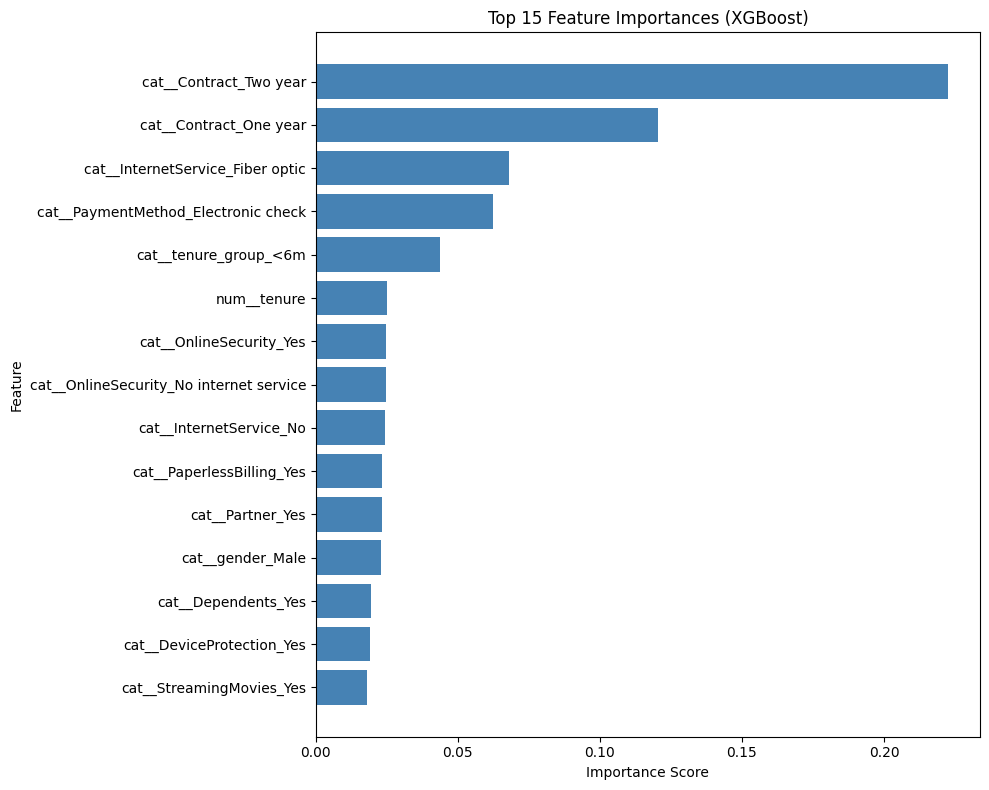

c:\Projects\CICD\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



ROC CURVE ANALYSIS

XGBoost AUC: 0.8449
Decision Tree AUC: 0.8178


c:\Projects\CICD\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


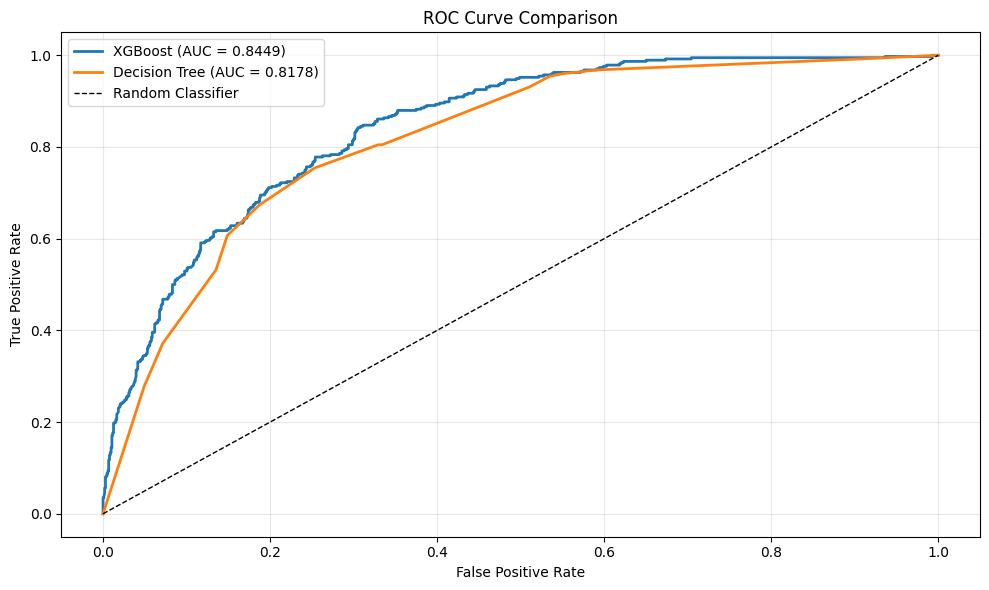


PRECISION-RECALL ANALYSIS


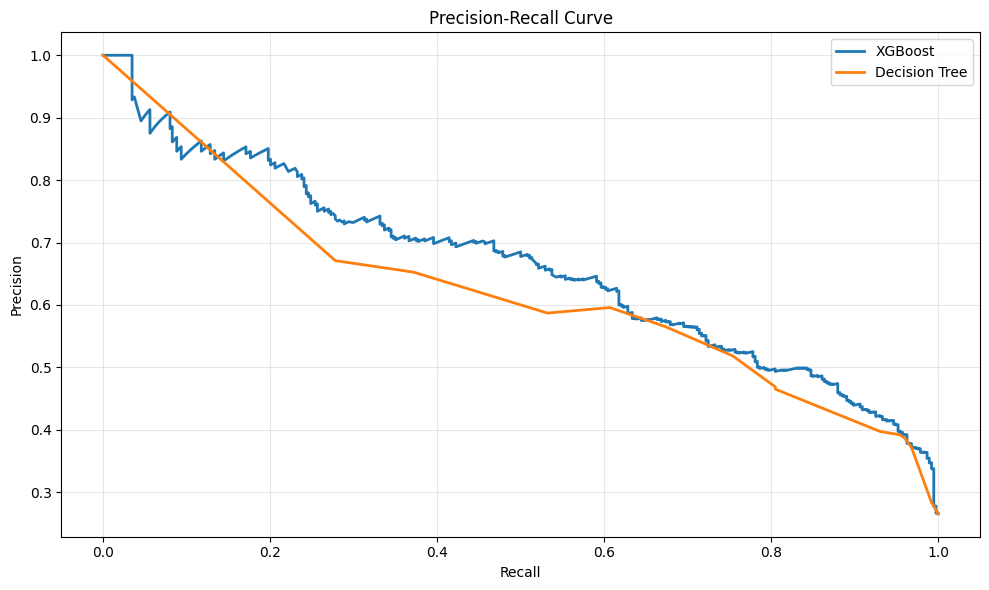


CONFUSION MATRIX VISUALIZATION


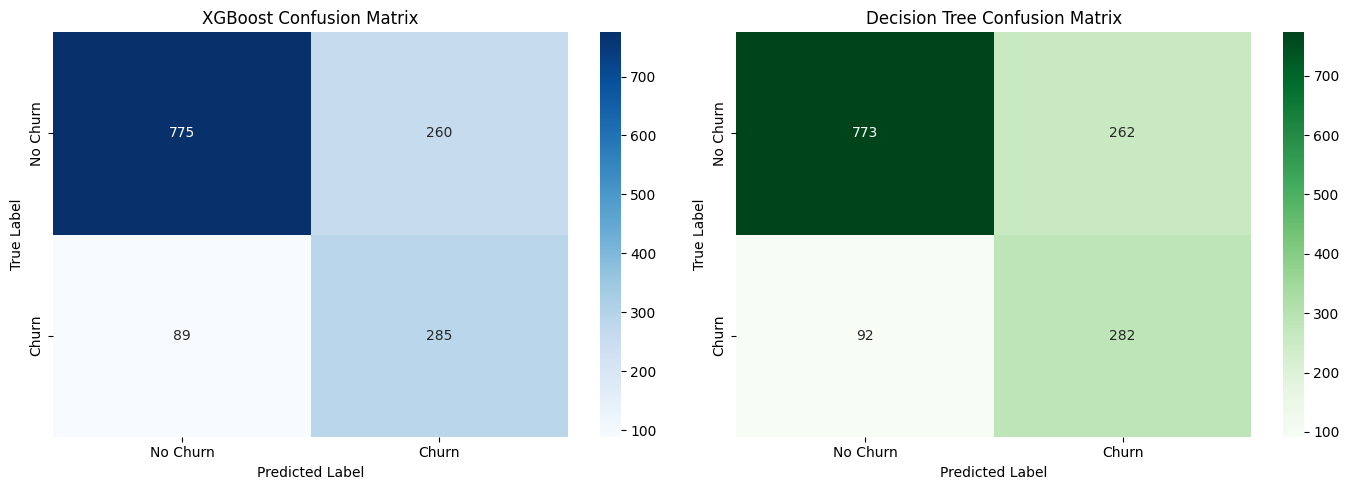


PREDICTION PROBABILITY DISTRIBUTION


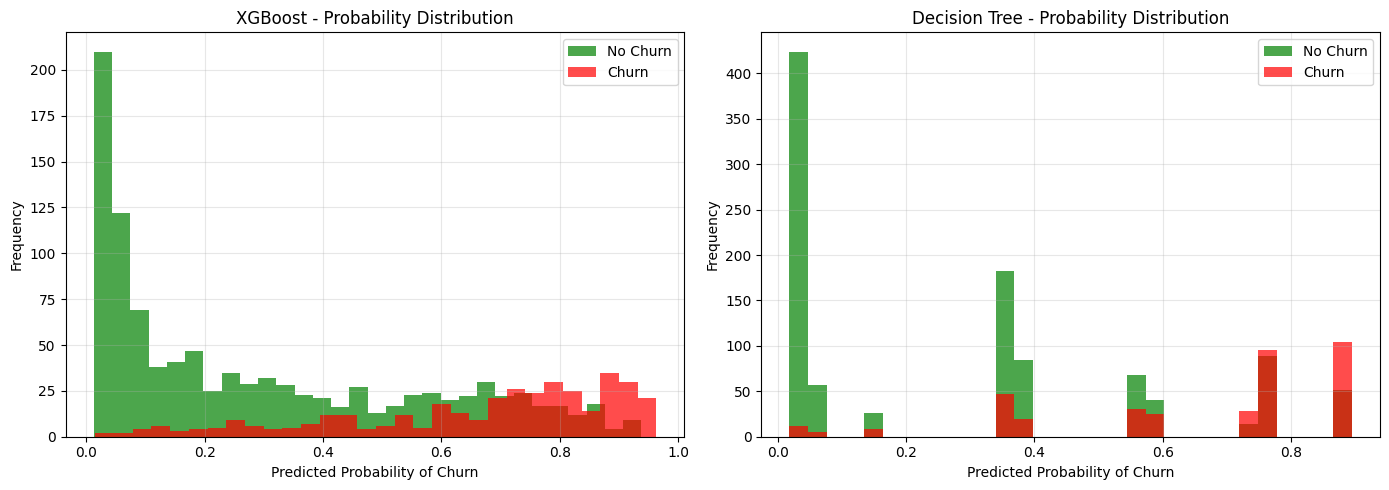


Model well-calibrated if:
  - Green bars (No Churn) cluster near 0
  - Red bars (Churn) cluster near 1

MODEL PERFORMANCE SUMMARY

               Accuracy  Precision    Recall  F1-Score   ROC-AUC
XGBoost        0.752307   0.522936  0.762032  0.620239  0.844909
Decision Tree  0.748758   0.518382  0.754011  0.614379  0.817801


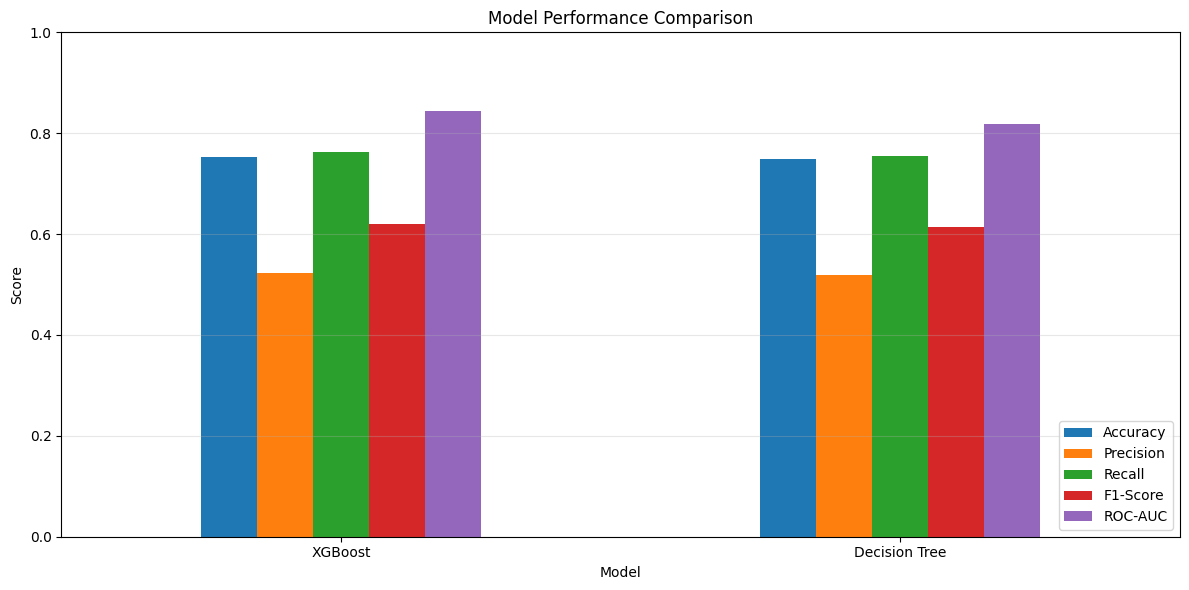


FEATURE IMPORTANCE BY CATEGORY

Importance by Feature Type:
                  sum      mean  count
category                              
Categorical  0.885925  0.000156   5661
Numerical    0.114076  0.011408     10


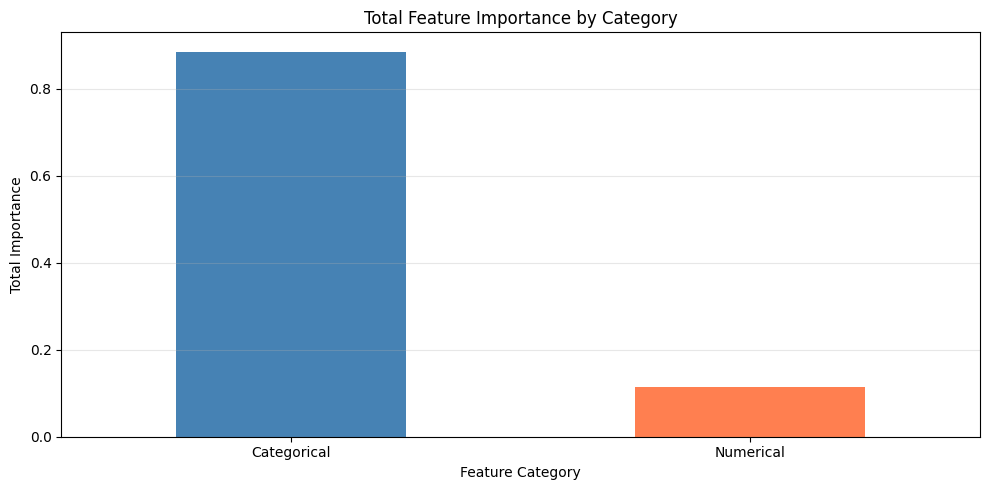

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve


# 1. EXTRACT FEATURE IMPORTANCES

# Get the trained XGBoost classifier from pipeline
xgb_clf = best_model_xgb.named_steps['classifier']

# Get feature names after preprocessing
try:
    feature_names = best_model_xgb.named_steps['preprocessor'].get_feature_names_out()
except:
    # Fallback: construct manually
    num_features = numerical_features
    cat_features = best_model_xgb.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_features)
    feature_names = list(num_features) + list(cat_features)

# Get importances
importances = xgb_clf.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Display top 10
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Plot top 15
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15).iloc[::-1]  # Reverse for better visualization
plt.barh(top_15['feature'], top_15['importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

# 2. ROC CURVE ANALYSIS

print("\n" + "="*60)
print("ROC CURVE ANALYSIS")
print("="*60)

# Get prediction probabilities
y_pred_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
y_pred_proba_dt = best_model_dt.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
fnr_xgb = 1 - tpr_xgb
fnr_dt = 1 - tpr_dt

# Calculate AUC scores
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print(f"\nXGBoost AUC: {auc_xgb:.4f}")
print(f"Decision Tree AUC: {auc_dt:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3. PRECISION-RECALL CURVE


print("\n" + "="*60)
print("PRECISION-RECALL ANALYSIS")
print("="*60)

# Calculate precision-recall curves
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall_xgb, precision_xgb, label='XGBoost', linewidth=2)
plt.plot(recall_dt, precision_dt, label='Decision Tree', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. CONFUSION MATRIX HEATMAP


print("\n" + "="*60)
print("CONFUSION MATRIX VISUALIZATION")
print("="*60)

from sklearn.metrics import confusion_matrix

# Create confusion matrices
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('XGBoost Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Decision Tree confusion matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Decision Tree Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 5. PREDICTION PROBABILITY DISTRIBUTION

print("\n" + "="*60)
print("PREDICTION PROBABILITY DISTRIBUTION")
print("="*60)

# Plot probability distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost
axes[0].hist(y_pred_proba_xgb[y_test == 0], bins=30, alpha=0.7, 
             label='No Churn', color='green')
axes[0].hist(y_pred_proba_xgb[y_test == 1], bins=30, alpha=0.7, 
             label='Churn', color='red')
axes[0].set_xlabel('Predicted Probability of Churn')
axes[0].set_ylabel('Frequency')
axes[0].set_title('XGBoost - Probability Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Decision Tree
axes[1].hist(y_pred_proba_dt[y_test == 0], bins=30, alpha=0.7, 
             label='No Churn', color='green')
axes[1].hist(y_pred_proba_dt[y_test == 1], bins=30, alpha=0.7, 
             label='Churn', color='red')
axes[1].set_xlabel('Predicted Probability of Churn')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Decision Tree - Probability Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nModel well-calibrated if:")
print("  - Green bars (No Churn) cluster near 0")
print("  - Red bars (Churn) cluster near 1")


# 6. MODEL PERFORMANCE SUMMARY


print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for both models
metrics_xgb = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': auc_xgb
}

metrics_dt = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1-Score': f1_score(y_test, y_pred_dt),
    'ROC-AUC': auc_dt
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'XGBoost': metrics_xgb,
    'Decision Tree': metrics_dt
}).T

print("\n" + comparison_df.to_string())

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# 7. FEATURE IMPORTANCE BY CATEGORY


print("\n" + "="*60)
print("FEATURE IMPORTANCE BY CATEGORY")
print("="*60)

# Categorize features
importance_df['category'] = importance_df['feature'].apply(
    lambda x: 'Numerical' if any(num in x for num in numerical_features) else 'Categorical'
)

# Group by category
category_importance = importance_df.groupby('category')['importance'].agg(['sum', 'mean', 'count'])
print("\nImportance by Feature Type:")
print(category_importance)

# Plot
plt.figure(figsize=(10, 5))
category_importance['sum'].plot(kind='bar', color=['steelblue', 'coral'])
plt.title('Total Feature Importance by Category')
plt.ylabel('Total Importance')
plt.xlabel('Feature Category')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier


voting = VotingClassifier(
    estimators=[
        ('xgb', best_model_xgb),
        ('dt', best_model_dt),
        ('lgbm', best_model_lgbm)
    ],
    voting='soft')

# Train Voting Classifier
voting.fit(X_train, y_train)
# Evaluate Voting Classifier
y_pred_voting = voting.predict(X_test)
print("\nVoting Classifier Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))

# Max FPR 0.2 for voting classifier
voting_pred_proba = voting.predict_proba(X_test)[:, 1]
fpr_voting, tpr_voting, _ = roc_curve(y_test, voting_pred_proba)

# Find threshold for max FPR 0.1
max_fpr = 0.1
threshold_index = next(i for i, fpr in enumerate(fpr_voting) if fpr > max_fpr)
threshold = _[threshold_index]
print(f"\nVoting Classifier Threshold for Max FPR {max_fpr}: {threshold:.4f}")

# Updated predictions based on threshold
y_pred_voting_thresholded = (voting_pred_proba >= threshold).astype(int)
print("\nClassification Report with Thresholding:")
print(classification_report(y_test, y_pred_voting_thresholded))

# Confusion Matrix with Thresholding
print("\nConfusion Matrix with Thresholding:")
print(confusion_matrix(y_test, y_pred_voting_thresholded))


c:\Projects\CICD\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:13:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4728
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

c:\Projects\CICD\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Projects\CICD\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Projects\CICD\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Projects\CICD\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Projects\CICD\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during